Create plot for full ensemble of SLR projections for 3 SSPs

Ensemble contains a range of ESMs and ISMs

Computation is done with and without feedback

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
import utils as ut

%load_ext autoreload
%autoreload 2

In [2]:
ds = xr.open_dataset('../data/dummy.nc')
ds = ds.isel(exp=slice(0,5))

In [3]:
mpl.rcParams['figure.subplot.wspace'] = .1
mpl.rcParams['figure.subplot.left'] = .1
mpl.rcParams['figure.subplot.right'] = .99
mpl.rcParams['figure.figsize'] = (7,3)

126 ACCESS-CM2 CISM_NCA 0.029978347591042454 0.04539147689785134
126 ACCESS-CM2 FETI_ULB 0.04655033419098318 0.08283787930807589
126 ACCESS-CM2 GRIS_LSC 0.025052382639989747 0.029859565025558258
126 ACCESS-CM2 IMAU_UU 0.07409644468405607 0.11836901733876504
126 ACCESS-CM2 ISSM_UCI 0.07524467501665642 0.10467646511502982
126 ACCESS-CM2 MALI_DOE 0.04537153375196218 0.07266847196844595
126 ACCESS-CM2 PISM_DMI 0.08616226085257611 0.21964058322186159
126 ACCESS-CM2 PISM_PIK 0.05958059075879608 0.0923759303820706
126 ACCESS-CM2 SICO_ILTS 0.1033027810189287 0.17641559212359123
126 CAMS-CSM1-0 CISM_NCA 0.04123245163974343 0.06243178915593141
126 CAMS-CSM1-0 FETI_ULB 0.06402569045924068 0.11393586127908285
126 CAMS-CSM1-0 GRIS_LSC 0.03445724126477129 0.04106907717848941
126 CAMS-CSM1-0 IMAU_UU 0.10191282434209797 0.1628056639293528
126 CAMS-CSM1-0 ISSM_UCI 0.10349210924152243 0.1439728214694662
126 CAMS-CSM1-0 MALI_DOE 0.06240435919849556 0.09994877960079074
126 CAMS-CSM1-0 PISM_DMI 0.118508241

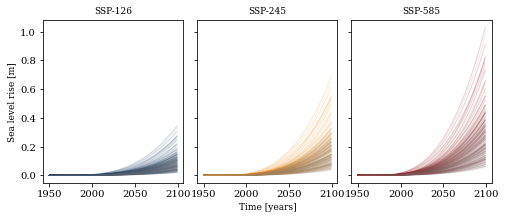

In [4]:
fig,ax = plt.subplots(1,3,sharex=True,sharey=True)

for s,ss in enumerate(ds.ssp.values):
    dax = ax[s]
    for e,es in enumerate(ds.esm.values):
        for i,ii in enumerate(ds.ism.values):
            TMP,IML,SLR = ut.iterate(ds,ism=ii,esm=es,ssp=ss,niter=2)
            dax.plot(ds.time,np.sum(SLR[0,:,:],axis=1),c='.5',lw=1,alpha=.1)
            dax.plot(ds.time,np.sum(SLR[-1,:,:],axis=1),c=ut.scol[ss],lw=1,alpha=.1)
            print(ss,es,ii,np.sum(SLR[0,-1,:]),np.sum(SLR[-1,-1,:]))
    dax.set_title(f'SSP-{ss}')

ax[0].set_ylabel('Sea level rise [m]')
ax[1].set_xlabel('Time [years]')

plt.savefig(f'../draftfigs/full_ensemble.png',dpi=450)
plt.show()